In [ ]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import skimage.draw
import random

In [ ]:
!git clone https://github.com/AlvaroPorcel/Dog_Segmentation.git

Cloning into 'Dog_Segmentation'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 62 (delta 5), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (62/62), 4.53 MiB | 9.72 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
cd Dog_Segmentation/

/content/Dog_Segmentation


In [ ]:
!python setup.py install

/usr/local/lib/python3.10/dist-packages/setuptools/dist.py:755: SetuptoolsDeprecationWarning: Invalid dash-separated options
!!

        ********************************************************************************
        Usage of dash-separated 'description-file' will not be supported in future
        versions. Please use the underscore name 'description_file' instead.

        This deprecation is overdue, please update your project and remove deprecated
        calls to avoid build errors in the future.

        See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
        ********************************************************************************

!!
  opt = self.warn_dash_deprecation(opt, section)
/usr/local/lib/python3.10/dist-packages/setuptools/dist.py:755: SetuptoolsDeprecationWarning: Invalid dash-separated options
!!

        ********************************************************************************
        Usage of dash-separ

In [ ]:
ROOT_DIR = '/content/Dog_Segmentation'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist'

sys.path.append(ROOT_DIR)

from mrcnn import visualize
from mrcnn.config import Config
from mrcnn import model as modellib, utils

In [ ]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [ ]:
class CascoConfig(Config):
    """Configuration for training on the helmet  dataset.
    """
    # Give the configuration a recognizable name
    NAME = "perro"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + oreja, ojos, hocico

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5

    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50
    POST_NMS_ROIS_INFERENCE = 500
    POST_NMS_ROIS_TRAINING = 1000

config = CascoConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [ ]:
import json
import os
import skimage.io
import numpy as np
from mrcnn import utils

class CascoDataset(utils.Dataset):

    def load_cascos(self, dataset_dir, subset):
        """Load a subset of the Casco dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes.
        self.add_class("perro", 1, "oreja")
        self.add_class("perro", 2, "ojos")
        self.add_class("perro", 3, "hocico")

        # Train or validation dataset?
        assert subset in ["train1", "val1"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations from JSON
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))

        # Iterate over images
        for image_id, annotation in annotations.items():
            filename = annotation["filename"]
            image_path = os.path.join(dataset_dir, filename)
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            polygons = []
            for region_id, region_data in annotation["regions"].items():
                shape_attributes = region_data["shape_attributes"]
                all_points_x = shape_attributes["all_points_x"]
                all_points_y = shape_attributes["all_points_y"]
                class_name = region_data["region_attributes"]["perro"]
                polygons.append({"name": class_name, "all_points_x": all_points_x, "all_points_y": all_points_y})

            self.add_image(
                "perro",
                image_id=image_id,  # use image_id as a unique image id
                path=image_path,
                width=width,
                height=height,
                polygons=polygons
            )

    def load_mask(self, image_id):
        """Generate instance masks and class IDs for shapes of the given image ID."""
        # Get image info
        info = self.image_info[image_id]
        # Initialize mask and class_ids lists
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],dtype=np.uint8)
        class_ids = []

        # Process each polygon
        for i, polygon in enumerate(info["polygons"]):
            # Extract polygon coordinates
            all_points_x = polygon["all_points_x"]
            all_points_y = polygon["all_points_y"]
            # Convert polygon to mask
            rr, cc = skimage.draw.polygon(all_points_y, all_points_x)
            mask[rr, cc, i] = 1
            # Map class name to class ID
            class_name = polygon["name"]
            if class_name == "oreja":
                class_id = 1
            elif class_name == "ojos":
                class_id = 2
            elif class_name == "hocico":
                class_id = 3
            else:
                class_id = 0
            class_ids.append(class_id)

        # Convert class_ids list to numpy array
        class_ids = np.array(class_ids, dtype=np.int32)

        # Return mask and class_ids
        return mask, class_ids




    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "perro":
            return info["path"]
        else:
            return super(self.__class__, self).image_reference(image_id)






In [ ]:
#Train Dataset
dataset_train = CascoDataset()
dataset_train.load_cascos("/content/Dog_Segmentation/dataset/partes_perro", "train1")
dataset_train.prepare()

# Validation dataset
dataset_val = CascoDataset()
dataset_val.load_cascos("/content/Dog_Segmentation/dataset/partes_perro", "val1")
dataset_val.prepare()

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

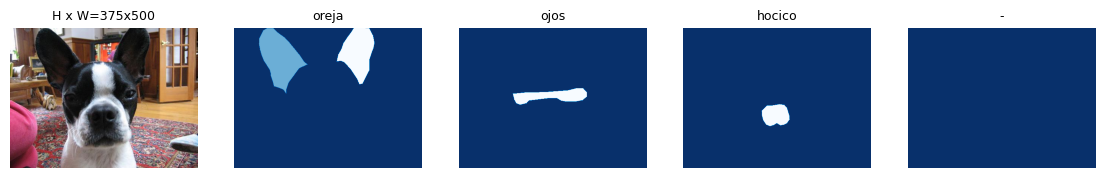

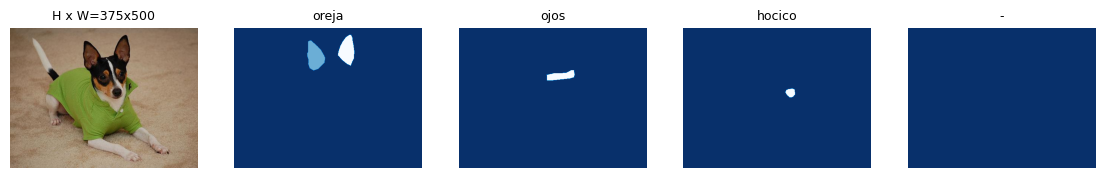

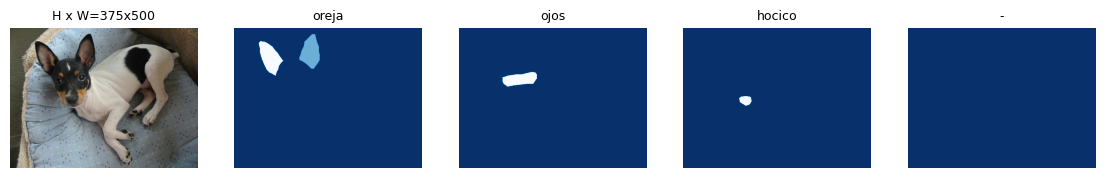

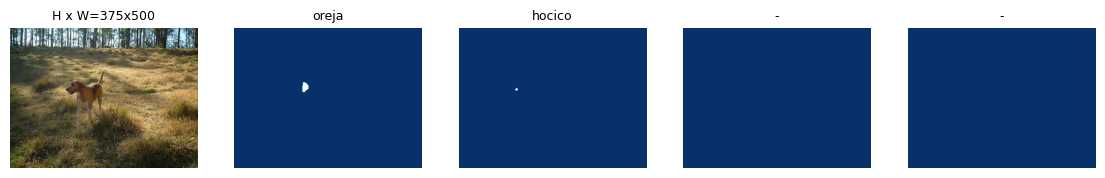

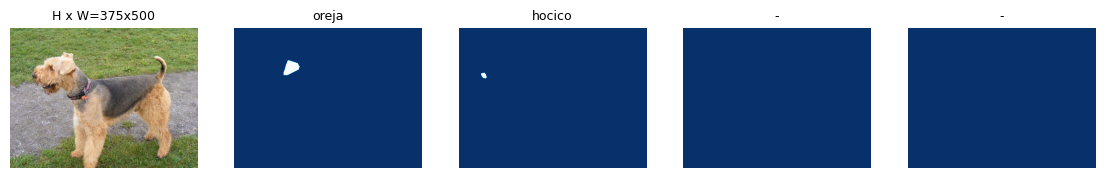

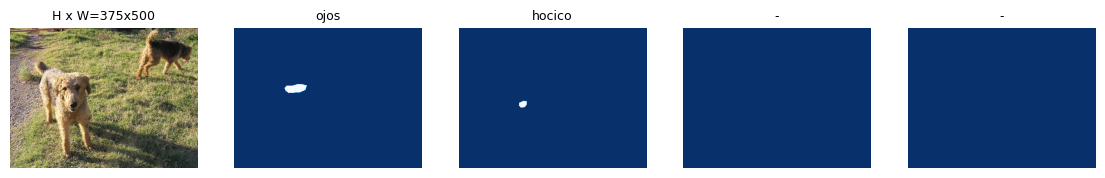

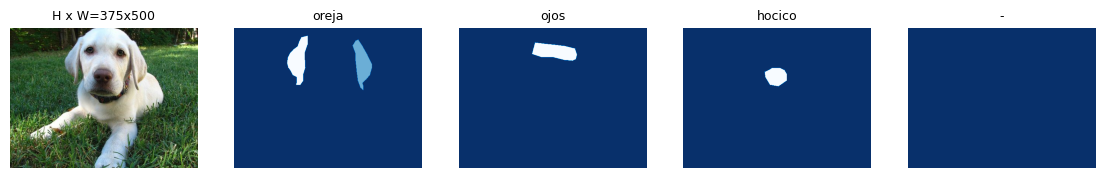

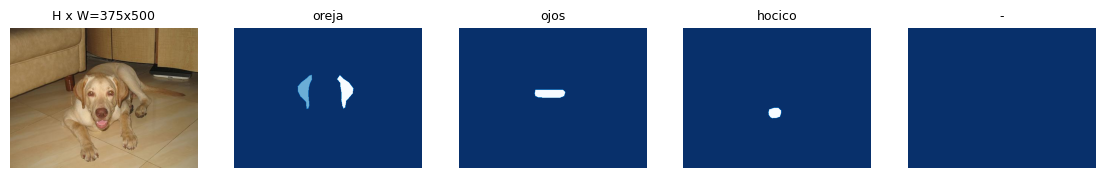

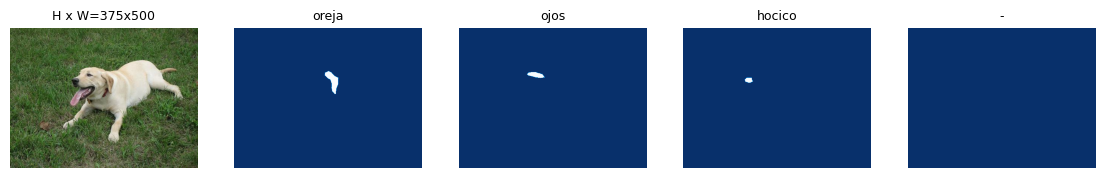

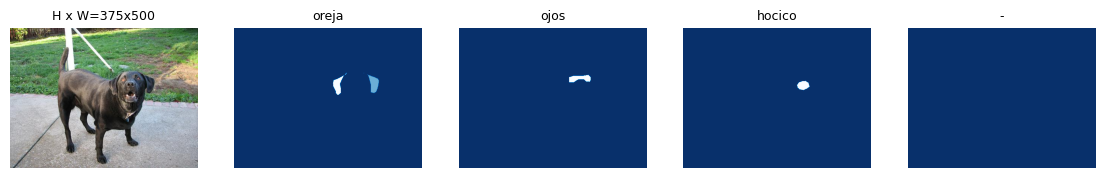

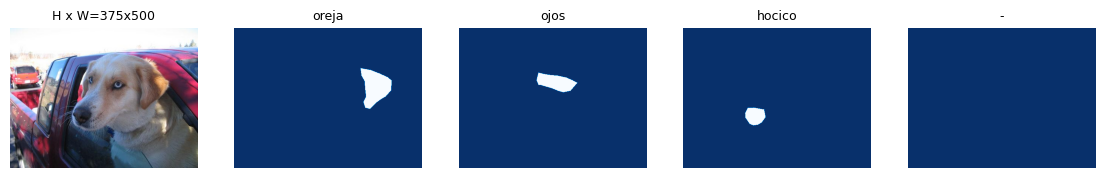

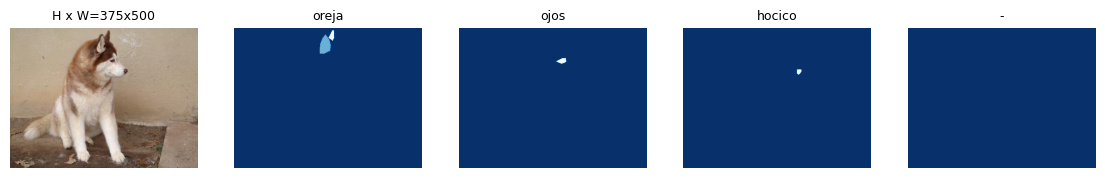

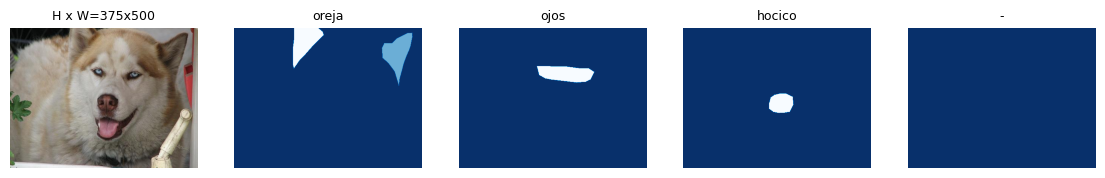

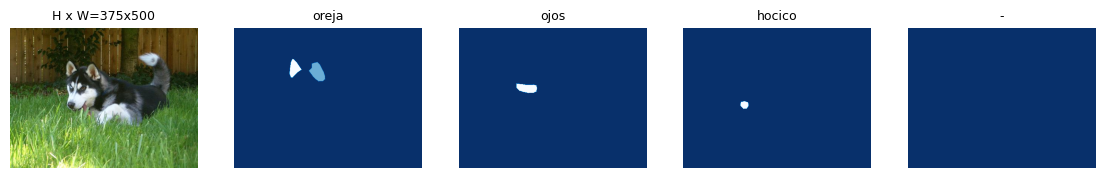

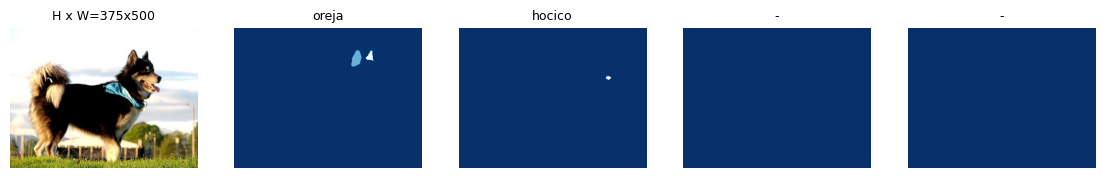

In [ ]:
# Load and display random samples
dataset = dataset_train
for image_id in dataset.image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)



image_id  12 /content/Dog_Segmentation/dataset/partes_perro/train1/n02110185_2446.jpg
image                    shape: (375, 500, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (375, 500, 4)         min:    0.00000  max:    1.00000  uint8
class_ids                shape: (4,)                  min:    1.00000  max:    3.00000  int32
bbox                     shape: (4, 4)                min:    1.00000  max:  475.00000  int32


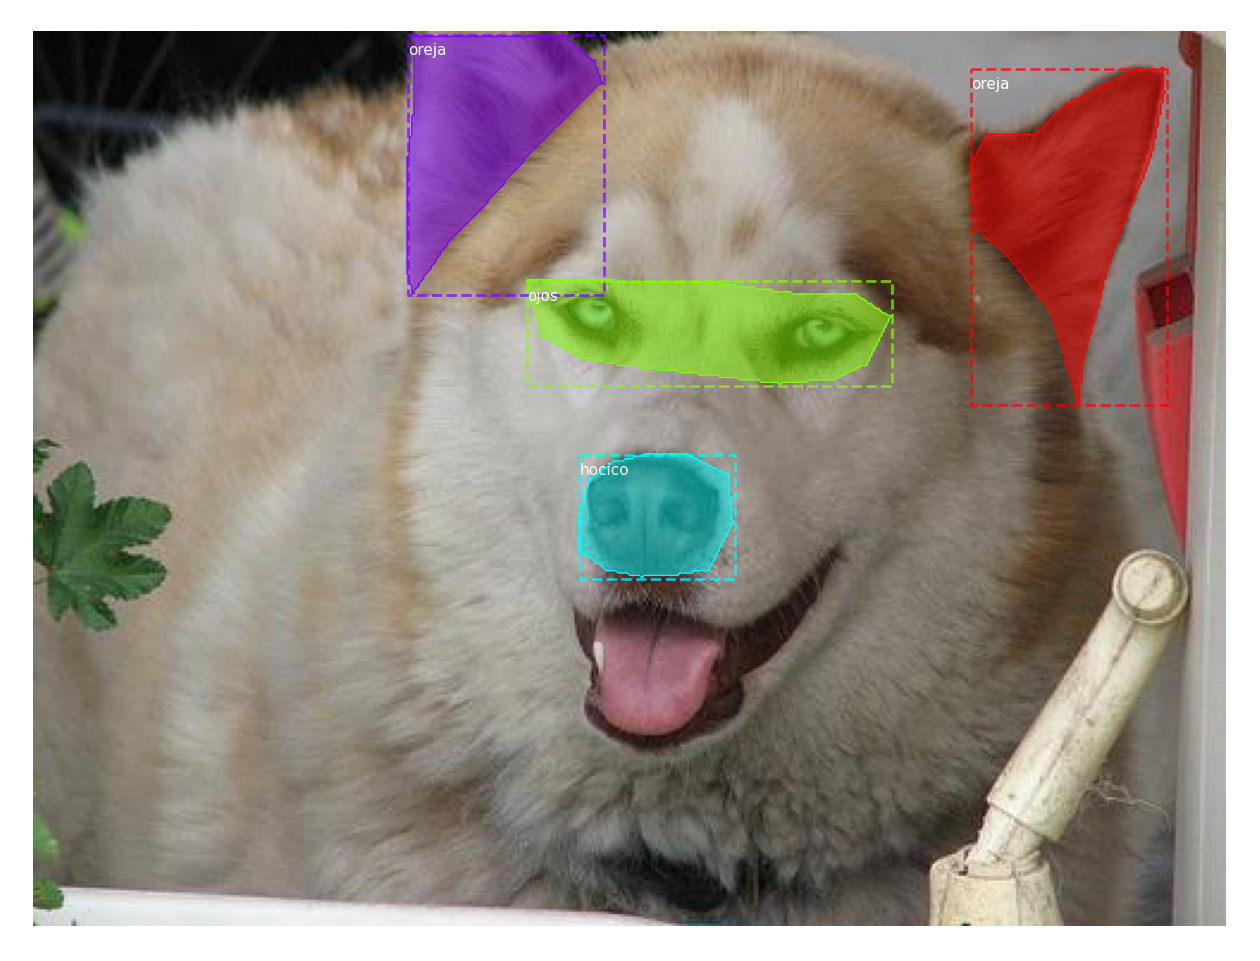

In [ ]:
from mrcnn.model import log
import numpy as np

# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)




# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [ ]:
#Entrenamiento del modelo
model.train(dataset_train, dataset_val,
            learning_rate=0.001,
            epochs=10,
            layers='heads')



Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Dog_Segmentation/logs/perro20240515T1634/mask_rcnn_perro_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv  

ValueError: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type.